<a href="https://colab.research.google.com/github/Eduzc07/machinelearning/blob/master/5_Midterm_StylexAI/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

## Import libraries

In [0]:
# Imports
import numpy as np
from PIL import Image
import requests

from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

from matplotlib.pyplot import imshow
%matplotlib inline

# Hyperparams
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

# Paths
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

# San Francisco
# san_francisco_image_path = "https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg"
image_path = "https://ep01.epimg.net/elpais/imagenes/2017/07/24/paco_nadal/1500918498_125283_1500930190_noticia_normal.jpg"

# Warsaw by Tytus Brzozowski, http://t-b.pl
# tytus_image_path = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"
#style_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
style_path = "https://upload.wikimedia.org/wikipedia/en/3/38/Gino_Severini%2C_1912%2C_Dynamic_Hieroglyphic_of_the_Bal_Tabarin%2C_oil_on_canvas_with_sequins%2C_161.6_x_156.2_cm_%2863.6_x_61.5_in.%29%2C_Museum_of_Modern_Art%2C_New_York.jpg"

## Create functions

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

def evaluate_loss_and_gradients(x, image, outputs):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients


def resizeCropImage(image):
    width, height = image.size

    new_width  = IMAGE_WIDTH
    new_height = int(new_width * height / width )

    new_height = IMAGE_HEIGHT
    new_width  = int(new_height * width / height)

    image = image.resize((new_width, new_height), Image.ANTIALIAS)
    #image.thumbnail((new_width, new_height), Image.ANTIALIAS)

    if (new_width > new_height):
      dx = int((new_width - IMAGE_WIDTH) / 2 )
      area = (dx, 0, dx + IMAGE_WIDTH, IMAGE_HEIGHT)
    else:
      dy = int((new_height - IMAGE_HEIGHT) / 2 )
      area = (0, dy, IMAGE_WIDTH, dy + IMAGE_HEIGHT)

    cropped_img = image.crop(area)
    return cropped_img

class Evaluator:
    def __init__(self):
        self.image = None
        self.outputs = None

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x, self.image, self.outputs)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

## Check Input Image

887 500


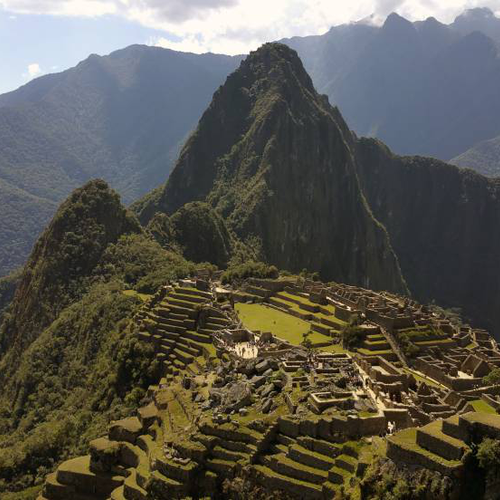

In [24]:
#Input visualization
input_image = Image.open(BytesIO(requests.get(image_path).content))
# input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image = resizeCropImage(input_image)
input_image.save(input_image_path)
input_image

## Check Style Image

631 500


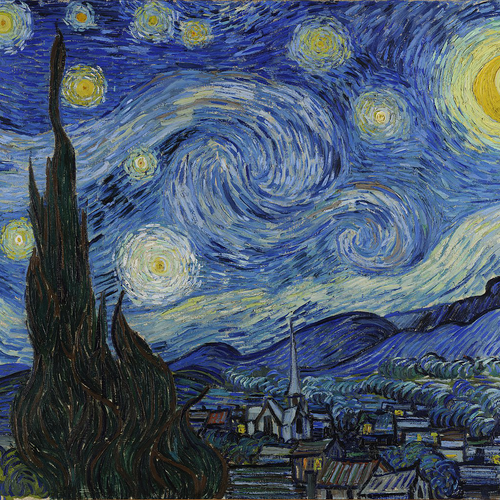

In [25]:
style_image = Image.open(BytesIO(requests.get(style_path).content))
# style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image = resizeCropImage(style_image)
style_image.save(style_image_path)
style_image

## Run Model

In [32]:
def model_transfer():
    print('Start Transfer------------------------------------------->')

    #Input visualization
    input_image = Image.open(BytesIO(requests.get(image_path).content))
    # input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    input_image = resizeCropImage(input_image)
    input_image.save(input_image_path)

    # Style visualization
    style_image = Image.open(BytesIO(requests.get(style_path).content))
    # style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    style_image = resizeCropImage(style_image)
    style_image.save(style_image_path)

    # Data normalization and reshaping from RGB to BGR
    input_image_array = np.asarray(input_image, dtype="float32")
    input_image_array = np.expand_dims(input_image_array, axis=0)
    input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
    input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
    input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
    input_image_array = input_image_array[:, :, :, ::-1]

    style_image_array = np.asarray(style_image, dtype="float32")
    style_image_array = np.expand_dims(style_image_array, axis=0)
    style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
    style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
    style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
    style_image_array = style_image_array[:, :, :, ::-1]

    # Model
    input_image = backend.variable(input_image_array)
    style_image = backend.variable(style_image_array)
    combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

    input_tensor = backend.concatenate([input_image, style_image, combination_image], axis=0)
    model = VGG16(input_tensor=input_tensor, include_top=False)

    layers = dict([(layer.name, layer.output) for layer in model.layers])

    content_layer = "block2_conv2"
    layer_features = layers[content_layer]
    content_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = backend.variable(0.)
    loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                          combination_features)

    style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
    for layer_name in style_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss = compute_style_loss(style_features, combination_features)
        loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

    loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

    outputs = [loss]
    outputs += backend.gradients(loss, combination_image)

    evaluator = Evaluator()
    evaluator.image = combination_image
    evaluator.outputs = outputs

    x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

    for i in range(ITERATIONS):
        x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
        print("Iteration %d completed with loss %d" % (i, loss))

    x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    x = x[:, :, ::-1]
    x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
    x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
    x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
    x = np.clip(x, 0, 255).astype("uint8")

    output_image = Image.fromarray(x)
    output_image.save(output_image_path)
    
    return output_image

print('Finished successfully!')

Finished successfully!


In [33]:
# Rewrite number of iterations
ITERATIONS = 20

output_image = model_transfer()

Start Transfer------------------------------------------->
887 500
487 500
Iteration 0 completed with loss 50154225664
Iteration 1 completed with loss 26054504448
Iteration 2 completed with loss 18636408832
Iteration 3 completed with loss 16394653696
Iteration 4 completed with loss 15288745984
Iteration 5 completed with loss 14575964160
Iteration 6 completed with loss 14091367424
Iteration 7 completed with loss 13755260928
Iteration 8 completed with loss 13510888448
Iteration 9 completed with loss 13343731712
Iteration 10 completed with loss 13228018688
Iteration 11 completed with loss 13146822656
Iteration 12 completed with loss 13090323456
Iteration 13 completed with loss 13048829952
Iteration 14 completed with loss 13016849408
Iteration 15 completed with loss 12992384000
Iteration 16 completed with loss 12973863936
Iteration 17 completed with loss 12959309824
Iteration 18 completed with loss 12947759104
Iteration 19 completed with loss 12937658368


## Result Visualization

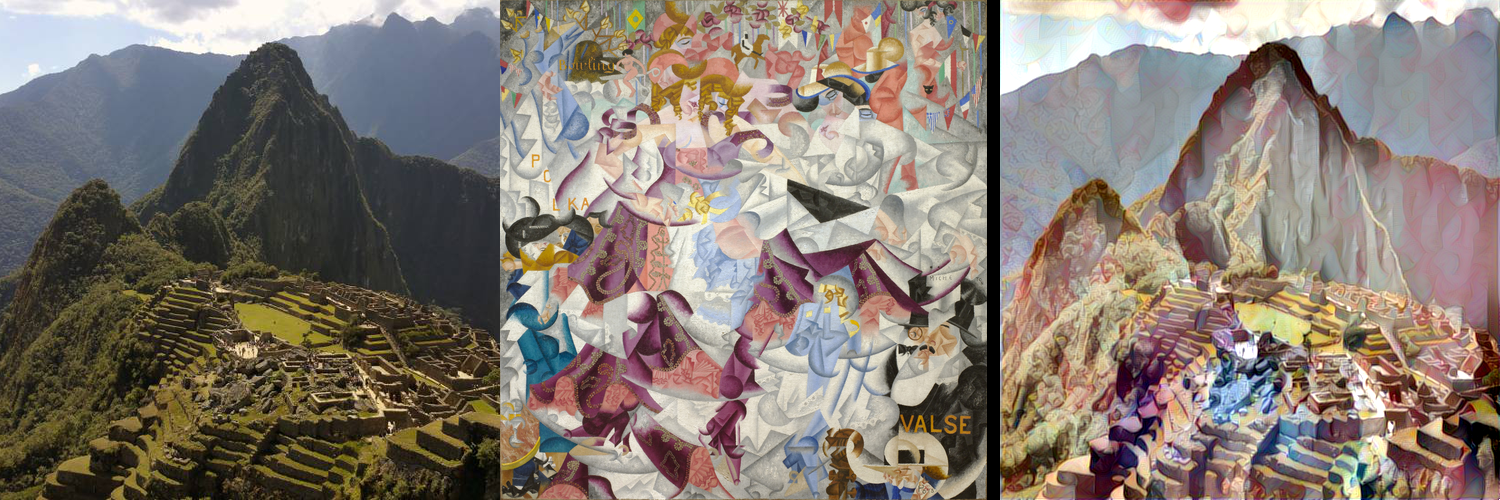

In [34]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined